<a href="https://colab.research.google.com/github/dmaxim/ufl-ai/blob/main/regress_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# linear regression in tensorflow

A step-by-step walthrough video on this exercise is available [here](https://youtu.be/7DycMJNHZO8).

In this notebook, you will use tensorflow to fit a linear model to simulated training data.

[Tensorflow](https://tensorflow.org) is a high-performance library for doing computations using "tensors", which is just a 'technical' term for the same "n-dimensional arrays" used by [numpy](https://numpy.org).

Technically "dimension" is a bit off. Really, we should be thinking about the "rank" of the "array" or "tensor". A "tensor" is a mathematical object that has 'magnitude' (a number) in multiple 'directions'. The number of possible simultaneous 'directions' is the tensor's "rank".

Well, that's pretty abstract, but that's math for you. Let's look at some examples.

A simple, regular number (called a "scalar") has rank zero. It's 'just a number'; the "base case".

A "vector" has rank one. It can be described as a 'list' of numbers, one for each "dimension" in the vector. For example, here's a vector with three dimensions (although it has rank 1!):

    [-1.0, 0.0, 2.38]

There are 3 numbers (scalars) in the vector, so it's dimension is 3. The following vecor has 4 numbers in it (dimension=4); it's rank is still one, though.

    [0.28, 12.51, -13.60, 22.79]

And this vector is 1-dimensional:

    [0.21]

It's also *different* from the scalar value, 0.21, which is a rank-zero entity. In tensorflow, we'll almost always use 1-dimensional vectors to hold single scalar values, rather than storing scalars as rank-zero entities.

Okay, so vectors have rank-1 and can be *any*-dimensional.

Matrices have rank two, and they can also be *any*-dimensional. For example, this matrix is 2x2-dimensional:

    [ 0.1  0.2 ]
    [ 1.9  2.1 ]

And this one is 2x3-dimensional (in row-major order):

    [ 0.2  0.1  0.0 ]
    [ 0.0  0.0  9.3 ]

In python, matrices and higher-ranked objects will need to be enclosed in outer-most brackets, like this:

    [ [ 0.1  0.2 ]
      [ 1.9  2.1 ] ]

Which makes it a bit more 'obvious' that the matrix can be thought of as a 'list' of vectors. The first rank in the matrix is used to 'hold' the vectors; its dimensionality is the number of vectors it contains. The second rank of the matrix is used to hold the scalars in each vector; its dimensionality is the number of scalars in each vector (ie, the dimensionality of the vector). This brings up an important limitation of the "tensor" framework - *all* the vectors in a matrix *must* have the *same* dimensionality. The following example is *not* a matrix

    [ [ 0.1  0.2  0.3  ]
      [ 1.9  2.1  ]      ]

because the first vector has dimensionality 3, while the second has dimensionality 2. This means that the dimensionality of the *matrix* is not defined, because the dimensionality of the matrix's second rank is either 2 or 3, depending on which vector you consider.

Once you get "higher-rank" than two, there is no 'special' name for the object, so you just call it a "tensor". More correctly, a "vector" is a "special name" for a rank-1 tensor, and a "matrix" is a "special name" for a rank-2 tensor. Can you guess what "scalar" is a "special name" for?

In any case, you can write a higher-rank tensor using the same square-bracket notation. For example,

    [ [ [1] [2] [3] ]
      [ [4] [5] [6] ]
      [ [7] [8] [9] ]
      [ [3] [2] [1] ] ]

this tensor has rank 3. It's "shape" can be written as:

    (4, 3, 1)

The "shape" of a tensor is a list of numbers (or a 'tuple'), one number for each rank of the tensor. There are 3 numbers in this shape tuple, indicating that the rank of the tensor is 3. The value of each number gives the dimensionality of the corresponding rank. In our example, then, there are 4 tensors in the first rank of the overall tensor, so the dimensionality of the first rank is 4. Each of the items in the first rank (they are technically matrices, but we can just call them "tensors") holds 3 items, so the dimensionality of the second rank is 3. Finally, there is a single scalar value in the inner-most square brackets, so the dimensionality of the third rank is 1.

For most of statistics, machine-learning and artificial-intelligence, just about *everything* is a "tensor". The "tensorflow" library is just a library that provides super-fast, GPU-accelerated operations on "tensors". Because so many things in AI are just operations on tensors, we can use tensorflow to do AI-related things super-fast, which is good for us!

To start using tensorflow, we need to import the tensorflow library. Because we don't like to type a lot of characters (and "tensorflow" is a lot of characters), it is common to import tensorflow like this:

In [1]:
import tensorflow as tf

Then we can use it like this:

In [2]:
print(tf.__version__)

2.12.0


If you get a 'name error', remember to run the first code cell, first!

Otherwise, you should see the current version of tensorflow, which when I first ran this code, was

    2.5.0


## simulating data for tensorflow

To fit a linear model in tensorflow, the first thing we need to do is generate some data.

Fortunately, we can just use scikit-learn to simulate our x,y training data, and then convert the numpy array from scikit_learn into a "tensor" dataset in tensorflow.

First, simulate the data using scikit-learn:

In [3]:
import sklearn.datasets

x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=1,
                                       bias=50.0,
                                       noise=10.0,
                                       random_state=221891)

Provided there is no error, that should have generated 100 x,y sample points.

We can plot them, of course:

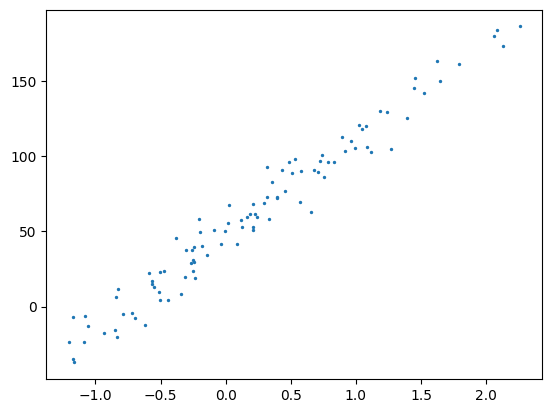

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x,y, marker='o', s=2)

That looks like about 100 x,y coordinates lying approximately on a diagonal line with y-intercept of 100.

Now we have our simulated data, but it isn't in a form that tensorflow can use. We need to 'convert' our simulated data from a numpy array to a tensorflow dataset.

Fortunately, there is a tensorflow function that does exactly what we want!

A data set in tensorflow is encapsulated as a "tensorflow.data.Dataset" object. Tensorflow is what's called an "object oriented" library, which just means that it uses a programming concept called an "object", which is just about as abstract a thing that you can have, even for a programming language.

An "object" in computer programming is a conceptual block of code that consists of data and operations (called "methods") that can be done on the data. A "Dataset" in tensorflow is an object that consists of "data" and "methods" that can be executed on the data.

Fortunately for us, unless we need to write our own new objects (we won't in this class!), we don't need to worry *too much* about what objects in tensorflow are. We just need to know how to use them!

To create a Dataset in tensorflow, we need to use the "static method" called "from_tensor_slices". A "static method" is technically a method that is called on the object's "class", without actually creating an object! But again, we don't need to really *understand* the technicalities of object-oriented programming in order to use it!

In [5]:
data = tf.data.Dataset.from_tensor_slices((x,y))

Provided there are no errors, we now have a tensorflow "Dataset" object stored in the "data" variable. The Dataset consists of our simulated x,y pairs. Basically, we give tensorflow our simulated x,y numpy arrays, and it converts them to a Dataset object for us!

A tensorflow Dataset object is *not* very useful *to us*. We can't plot it or print it or easily extract or add elements to it. All these things are *much* easier to do using numpy arrays.

But that tensorflow Dataset object is *very* usefult *to tensorflow*. Packaging our data as a tensorflow Dataset object will allow tensorflow to *efficiently* use our data to train AI systems. It also makes coding the AI-training process *much* easier (for us!). So, we pay a little bit of up-front headache packaging our numpy data into a tensorflow Dataset object, but it's a 'win-win' in the long-run.

The take-home from the previous code-block is that we can create a tensorflow Dataset object by using the static method:

    tf.data.Dataset.from_tensor_slices(INPUT)

where we replace "INPUT" with our own data, wherever it came from. In our case, our simulated x,y pairs were stored in the "x" and "y" variables, respectively. We created the INPUT parameter by 'packing' x and y into a python "tuple", using the "(" and ")" symbols (open- and close-parenthesis, respectively).

A python "tuple" is an ordered list of items, which is immutable (cannot be changed) after its creation. If we have python variables "x" and "y", we can create a "tuple" holding x,y pairs with the python syntax:

    (x,y)

which is the INPUT to the from_tensor_slices method.

We stored our tensorflow Dataset in the variable "data", so we can use it later.

## tensorflow linear model

We have simulated our training data and packaged it for tensorflow. The next thing we need is a linear model.

Well, a neural network can quite easily be used to implement a linear model.

In fact, we know that *any* neural network lacking non-linear activations is just a linear model!

But why 'waste' model parameters; we'll go with the *simplest* neural network that is a linear model, which is just a single-neuron with linear activation.

Even though this *particular* network is very simple, the *exact same* procedure is used to build *any* neural network in tensorflow (at least approximately; some really odd models require you to build your own objects, but these are pretty rare cases). Once you get the basic procedure down, you can use the same procedure to generate *very* complex state-of-the-art models.

The approach we'll use to build our neural network models is based on the "Keras" application programming interface (API, a specification for communicating information across programs). Basically, the "Keras API" specifies how to create and use neural network models, and the implimentation of that "interface" is entirely up to the application.

Tensorflow has implemented the Keras API, so we can use that API to create and train our model, and tensorflow will take care of the rest!

The simplest type of neural network is a simple "feed-forward" model, in which information proceeds sequentially through each layer in the model. Interestingly, a *large number* of existing neural network models are 'just' sequential models using simple building blocks. Even more 'cutting edge' architectures that use multiple complex data branches and joins (like "residual" or "dense" architectures, as well as U-shaped networks used in various fields) can be implemented as sequential models of more complex computations (using custom sub-classes to create new objects). The take-home message here is that sequential models (although 'simple'), actually account for at least 90% of all neural network architectures. It *may* be that *any* neural network could be encoded sequentially; can any directed acyclic graph be embedded in a linear sequence? I'll leave that math for those better than I, though :)

For our purposes, we can implement *a lot* of *very* complex models using the Keras Sequential framework.

So, let's build a Sequential model using Keras in tensorflow...

In [ ]:
model = tf.keras.models.Sequential()

whew... that's some heavy-lifting! :)

That one line of python code created a new sequential model.

Unfortunately... that model is "empty". There's "nothing" in it, at all. No computation. No data. nothing. kinda sad... empty... model...

A Sequential model can be thought of as a 'list' of layers, with the output from the preceding layer being the input of the subsequent layer. The Sequential model object will handl all that information passing for us, but right now there are *no* layers in the model. So, let's create a linear model and put it in our model as the first layer.

We'll use a Keras "Layer" object to implement our linear model. A "Layer" in Keras implents a neural network "layer"; a collection of neurons all connected to the same inputs. Layers can be as complex as you'd like, and there are many 'advanced' neuron types that do fairly complex operations. All of these 'advanced' neurons are built using smaller components, which are built using smaller components... which are implemented using linear models (combined with non-linear activations). Once we really 'understand' the simplest case, we can use the same code to run much more complex models, just by 'swapping in' a different type of "Layer" object.

But all we need *now* is a simple linear model, so we can use the Keras "Dense" Layer. The "Dense" layer implements a 'densely connected' neural network layer. The Dense layer can consist of *any number* of neurons, each of which will be connected to *all* the layer's inputs. Each input has a "weight" (trainable parameter) and (optionally) a "bias". Each neuron accepts *all* the inputs and returns the linear-sum of the weighted input values, plus the bias term. All weights and biases (one for each neuron in the Layer) are trainable parameters of the model.

That sounds pretty complicated, but if we use a layer having only 1 neuron, we know a single neuron is just a simple linear model, so we have our linear model implementation as a single-neuron Dense Layer Sequential Model. If we want to make the model more complex, we can add more neurons in the Dense layer - this would create a multi-linear model (multiple ys fit to the same xs), but we don't need that for our problem.

Let's build the network layer and add it to our model, implementing the linear model in tensorflow.

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=[1]))

Line 1 is just reproduced from the code cell above, so we don't end up inadvertently adding multiple layers to our model. It just creates an empty sequential model.

Line 2 implements the simple linear model.

We're actually doing three things here.

1.  implementing a simple linear model in 1 dimension using a "Dense" neural network layer with 1 neuron.
2.  adding the linear model to our sequential model, so we can fit it to data later on.
3.  specifying the rank and dimensionality of the input tensor, so tensorflow knows how to build the model.

To implement the single-neuron Dense layer (ie, 'simple linear model'), we specify the "units=1" option to the "tf.keras.layers.Dense(...)" constructor, telling it we want a single neuron layer. If we wanted 2 neurons, we could specify

    units=2

or any number we'd wish, but for now we just want a simple linear model, so we'll just stick with

    units=1

The code

    model.add(...)

adds the new Dense layer to the model, which was previously an empty model. If you wanted a second layer, you could just execute another call to

    model.add(...)

with a different layer specification. But for now we only need 1 layer, so we don't need to call "model.add" again.

Finally, we need to specify 'the rank and dimesionality of the input tensor'. That sounds like it could trip us up. Thankfully, the 'syntax' is pretty simple, especially in our case. We have 1-dimensional data; one input scalar "x" is mapped to one output scalar "y". We specify this 'shape' as

    [1]

to tell the tensorflow model to be built in 1 dimension ("1"), with input tensors of rank 1 (because there is a single value between "[", and "]"). We'll need more complex input shapes later on, when we work with multi-dimensional and multi-rank predictors, but for now the input specification is pretty simple.

We specify the shape of the input data using the

    input_shape=INPUT

option, when we create the *first* layer in our network. There are alternative ways to specify the input shape, but this is convenient in most cases.

In our case, we set input_shape equal to the data specification of our simple linear model in 1 dimension.

    input_shape=[1]

Now that our simple linear model is built, we can 'see' it using the model's "summary" method:

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


The model's 'summary' is a 'human-readable' representation of the tensorflow model.

The summary of a Sequential model is just a list of Layers. Each Layer has a "name" or identifier, which tensorflow will automatically generate, or you can set the name of your Layer when you create it. The Layer's "type" is the Keras class used for the layer. In our case, we used "tf.keras.layers.Dense" to create our layer, so the layer's "type" is "Dense".

The shape of each Layer's output is also listed. In our simple linear model, we want to predict a single scalar value (y), so the "output shape" of our model should be a 1-dimensional tensor of rank one (remember that we very rarely use zero-rank tensors in tensorflow). Tensorflow automatically adds the "None" dimension to *all* inputs and outputs, as a convenience to allow "batched training". We'll explain batched training later on in this notebook; for now we can just ignore the "None" dimension of our Layer's output.

The number of free model parameters (ie, "trainable" parameters) in each layer is also reported, and at the bottom we have a summary of the *total* parameter count for *all* layers in our model. In our simple linear model, there is only a single layer, so the parameter count for our single layer is *also* the parameter count for the entire model. Recall that a simple linear model has 2 parameters (slope m and y-intercept or "bias" b); the parameter count of our model reflects this.

You can also "name" your model, or tensorflow will automatically give it a unique name, which is listed at the top of the summary.

## specify the loss function

To fit our linear model to data, we need to specify a "loss function" that will tell us how 'far away' from the true y-values our predicted y-values are. We can then 'optimize' the parameters of our model to 'minimize' the loss function, providing the 'best fit' parameter values, given the training data and specified loss function.

Because the Keras API is object-oriented, just about *everything* is an object, including the loss function. So, to specify a loss function, we just create (often referred to as "instantiate") an object of the type required to implement whatever loss function we want.

Luckily for us, tensorflow comes with *many* different commonly-used loss functions, so we just need to pick the one we want. Loss functions are stored in the sub-library "tf.keras.losses"; they are all sub-classes of the "Loss" class.

For our linear model, we'd like to use mean-squared-error as our loss function, like we did previously when we coded the linear model 'by hand' in python. The tensorflow object that implements mean-squared-error loss is called "tf.keras.losses.MeanSquaredError", so we can create a mean-squared-error loss function like this:

In [8]:
lossfn = tf.keras.losses.MeanSquaredError()

If there are no errors, we just created our mean-squared-error loss function and stored it in the python variable "lossfn", so we can use it later.

If there is an error, we probably need to scroll back and re-run each of the code cells in this notebook, to update the state of execution.

## specify the optimizer

When we coded the linear model by hand using python, we 'optimized' the model ourselves, by trying various values for m and b, and observing the effect on the loss function.

We don't want to optimize neural networks with millions of parameters this way!

Fortunately, tensorflow is quite happy to optimize our models for us, and it is pretty efficient at doing so. However, we need to tell tensorflow *how* we would like to optimize our model's parameter values.

An "Optimizer" is an object (imagine that!) that 'updates' the weights of our model, based on the specified loss function and the 'gradients' calculated during back-propagation.

Basically, neural network "training" works by randomly initializing the weights (aka, "parameters") of the model, just so they have some initial values (don't worry, tensorflow will do this for us!). Then, we take the training data (x), and predict the response (y) using the model. We use the loss function to calculate how 'bad' our predicted response (y&#770;) is from the 'true' response (y). This is called the "forward pass" through the model.

After the forward pass, we perform "back propagation" to calculate the gradients associated with each weight in the network. The gradient is essentially a generalization of the first derivative from calculus; it tells us, for *every* weight in the model, how much of an effect on the model's loss it would have to *slightly* change that weight. Basically, the gradient of a weight tells us *how much* and *in what direction* to change that weight, in order to *improve* the model's overall loss.

The gradients are then handed to the Optimizer, which determines how to actually update the model's weights. There are *a lot* of different Optimizers, and they can get fairly complicated, as you can imagine that optimizing a deep neural network with 20-million parameters might be a bit challenging!

For our simple model, we can use a fairly 'standard' neural network optimizer called "stochastic gradient descent". Stochastic gradient descent is the 'workhorse' of neural network optimizers. It tends to work 'pretty well' in a variety of cases, and it has been used to train a large number of deep networks. Many of the more 'fancy' optimizers were built on a stochastic gradient descent 'backbone'.

Tensorflow Optimizers are sub-classes of the "tf.keras.optimizers.Optimizer" 'base class', so we just need to choose the one we want, and then instantiate it. The stochastic gradient descent optimizer is called "tf.keras.optimizers.SGD", so we can instantiate one like this:

In [9]:
optmzr = tf.keras.optimizers.SGD()

No errors. Done.

Now we have our neural network optimizer stored in the variable "optmzr", for future use.

## compile the model

Before we fit our model to the training data, we need to do one more thing. We need to add the loss function and the optimizer we created to the model. This process is called "compiling" the model in tensorflow.

We can "compile" a model in tensorflow by calling its "compile" method, providing options to specify the optimizer and loss function we selected:

In [10]:
model.compile(optimizer=optmzr,
              loss=lossfn)

That's it. Now our linear model is ready to fit to training data, using the specified loss function (mean squared error) and optimizer (stochastic gradient descent).

## fit the model to training data

Finally, we can fit our model to our training data! But wait... not... quite... yet.

First we need to learn a couple of concepts about how neural networks are "trained" (ie, fit to training data), and we need to see how these concepts are *implemented* in tensorflow, so we can use them to train our model.

The two concepts we will be looking at are

*  batch
*  epoch

To learn about these concepts, we need to first take a rather high-level view of the neural network training process.

Recall that the basic procedure in neural network training starts with a neural network having values for *all* the weights in the network. Initially, these weights are 'randomly initialized' to starting values. A 'single pass' through the training procedure calculates the loss function, given the current weights of the network, calculates the gradients, and then uses the gradients (and the optimizer) to 'update' the model's weights, providing new weights for the next pass through the training process.

The question we must answer is, "how many data samples should we analyze, before updating the model's weights in a 'single pass' through the training process?"

There are two 'extreme' answers to this question. First, we could decide to only analyze 1 training data sample, and then *immediately* update the model's weights, based on just this one training sample. This approach is quick, because we update the model's weights from just one calculation. Unfortunately, this approach also tends to suffer from a 'noisy gradients' problem. Remember that estimating values from *a single data point* is almost *never* a good idea, statistically! Using this single-data-update approach, the gradients tend to have trouble 'pointing in the right direction' due to statistical noise, so the optimizer can have a lot of trouble optimizing the model!

The alternative 'extreme' approach is to only update the model's weights after analyzing *every* training data sample. This approach could be called "epoch based training", as an "epoch" refers to the model analyzing *every* sample in the training data set once. (In the literature, "epoch based training" is often referred to as "batch training", which is *very* confusing, but you should be aware of this terminology). Epoch-based training tends to be more 'stable' than updating the weights after each data sample is analyzed, because the gradients tend to be more well-behaved when averaged over *many* data samples (so, statistics works!). The *major* down-side to the epoch-based approach is that you have to do *a lot* of computation for *each* weight update, so model fitting takes *a lot* more time.

The 'compromise' between single-data and epoch-based training is what I will call "batch based training" (it is very often called "mini-batch training" in the literature and online). In the batch based approach, the user selects a value for the "batch size", which determines *how many* training data samples the model will analyze *before* updating its weights once. Obviously, the *smallest* possible batch size is 1 (equivalent to single-data training), and the *largest* possible batch size is the size of the entire training data set (equivalent to epoch-based training). Setting a batch size somewhere between these two extremes allows the user to 'balance' gradient stabilization (larger batch size stabilizes the gradients used to update the weights) vs computational efficiency (smaller batch size produces *more* gradient updates, per calculation).

In practice, common batch sizes are typically between 32 and 256 for *most* neural network training applications. And yes, they are *very often* a power of 2! Computer programmers *love* powers of 2, and the AI folks are no different (probably *more* so!). The *really nice* thing about powers of 2 is that you can *always* divide it in half! This can be *really* useful when, for example, you'd like to efficiently up-sample or down-sample some image data; you *always* know you can do it without having to do any weird pixel interpolations. In any case, be prepared to see (and use) many powers-of-2 if you do any work in AI :)

The way batch-based training works is... You divide your training data set into 'batches' of user-specified size. So, say we set a batch size of 10; that means we'll divide our data into 'chunks' of size 10 data samples. We still say that a pass through the *entire* data set is an "epoch", but now our "epoch" has been divided into "batches" of a fixed size (10, in our case).

To update our model's weights, we first pass *all* the data samples *in a single batch* through our model. Remember that "None" dimension in our model summary? That "None" dimension allows tensorflow to process an entire batch as a single unit, which makes it *much* faster! In our example, 10 data samples will be packaged and passed through our model as a single unit. The model then calculates the loss over the entire batch (all 10 samples), calculates the gradients across the entire batch, and then uses the batch-gradients to update the model's weights (via the optimizer).

It's pretty easy to create batched training data in tensorflow. We already have our training data in the "data" variable, which is a tensorflow Dataset object. We just have to call the "batch" method on the "data" object, which will 'package' the training data into whatever batch-size 'chunks' we want. To use the batched data, we'll need to store it in a variable for later. We'll store it *back* in the "data" variable:

In [11]:
data = data.batch(10)

Now we have batched training data, with batch size 10.

A single pass through our training data set is called an "epoch" of training. Over the course of the epoch, the model's weights will be updated approximately

    dataset_size / batch_size

number of times.

In nearly *all* cases, this is *not* enough model updates to fit the model to the training data. We need to fit the model over *many* passes through the entire data set (ie, many "epochs"), before the model's weights approach their 'best fit' values.

We specify the number of epochs to train for when we tell tensorflow to fit our model to the batched training data. Deep neural networks often require training over tens-of-thousands or hundreds-of-thousands of epochs before their weights approach 'usable' values (ie, 'approximately optimal'?), even when adaptive optimization and other 'fancy' training routines are used. For simple models like our linear model, we can just train for a hundred epochs or so, and our model weights should be pretty close to optimal.

To fit the model to data in tensorflow, we call the "fit" method on the model object, providing the batched training data, and set the "epochs" option to the number of epochs of training.

In our example, we will train our linear model for 100 epochs, using the training Dataset stored in the "data" variable, which holds our batched data.

When you execute the following code cell, it will launch the neural network training process in tensorflow, which is nearly *all* of the computation in AI. All of the previous work spent packaging Dataset objects and compiling models and such was designed so that this *specific* step can be done as *efficiently* and *quickly* as possible. As the model is fit to the data, tensorflow will print some information to the screen showing the progress of each epoch, as well as the currently-calculated loss value, which is frozen and reported at the end of each epoch of training.

You should see the loss value steadily decrease over epochs from a pretty large initial value to smaller and smaller values as the model is fit.

In [12]:
model.fit(data, epochs=100)

Epoch 1/100
10/10 [==============================] - 1s 2ms/step - loss: 5642.1323
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 3683.9126
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 2428.0479
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 1620.3779
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 1099.2197
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 761.6077
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 541.8811
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 398.1013
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 303.4291
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 240.6473
Epoch 11/100
10/10 [==============================] - 0s 2ms/step - loss: 198.6801
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 170.3781
Epoch 13

In my case, the loss function's value at the end of training was around 104.7, from an initial starting value (you'll need to scroll up to see it) of over 5000. The exact values will vary from problem-to-problem and so don't matter that much.

You will perhaps notice that the minmal loss value appears to have 'plateaued' by the end of trainning - it stabilized and didn't continue to get better and better at the end. This is indicative of finding a model parameter 'optimum', although in complex loss-function 'spaces', the optimum may be 'local' and not the global 'best fit'.

## predict y values using our fit linear model

Now that our model has been 'fit' to our training data, we can use it to predict new response variables (y), given new input variables (x). To do this, we basically do the same 'forward pass' through our model as we did during training, although we *don't* need to calculate any gradients or update any model weights.

The forward pass in a neural network is *fast*, so *using* a neural network, once it has been trained, is *very* computationally efficient. This is one of the main advantages of neural networks in AI; although it takes a *long time* to train a neural network, the network can actually make decisions in near *real-time*.

For now, we just want to 'see' how 'good' our neural network was fit to the training data. So, we can use the trained network to calculate the 'predicted' y value of each x-value in the training dataset, and then we'll plot the predicted y-values (y&#770;) along with the 'true' simulated y-values, to 'see' how fit our model is.

Calculating the predicted y-values is easy!

In [13]:
yhat = model.predict(x)

4/4 [==============================] - 0s 3ms/step


Let's use the same plotting function as before to plot our predicted-vs-true data.

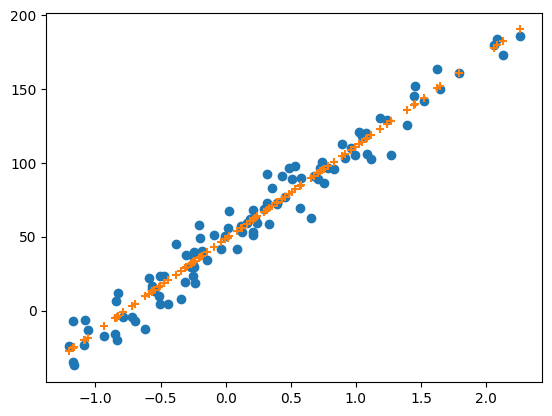

In [14]:
def plot_prediction(x, y_true, y_pred):
  plt.scatter(x, y_true, marker='o')
  plt.scatter(x, y_pred, marker='+')

plot_prediction(x, y, yhat)

Does that look like a 'good' model fit?

The orange "+" is the predicted data from our linear model; it should *always* fall *exactly* on a straight line. The blue circles are the true data used to train the linear model.

If the Optimizer worked properly, mean squared error loss should *minimize* the average squared distance of each orange + to its corresponding 'true' blue circle.

It looks like our approach did a pretty good job of fitting a linear model to our training data.

However, due to the 'stochastic' nature of neural network training, we cannot *guarantee* that this is *precisely* the 'best-fit' line to these data! Neural network training is *only* an *approximation* to model parameter 'optimization'; it is not guaranteed to give you the actual optimal results. There are other algorithms that *are guaranteed* to give you optimal results, and for linear models they are *much* faster than neural network training. So, why would we *ever* use a *slower* method that is also *not as good*?

The reason we 'prefer' stochastic optimization is that it "scales" much better to larger problems. Once the number of parameters in the model starts getting large, or the model becomes non-linear by adding non-linear activations, stochastic optimization methods like neural network training suddenly become both *much faster* and *much more accurate* than methods that work better in low-dimensional problems.

So, while there are 'better' ways to fit a linear model than stochastic gradient descent, the training method we chose 'generalizes better' to larger models, so it's worth it to learn it. As we'll see later on, fitting more complex models is *the same* in tensorflow, so we *won't* need to learn much more code, and we can concentrate on actually building cool and useful models.

## complete example

That was a lot of short code cells with *a lot* of explanation and narration along the way.

Here we reproduce the end-to-end working example of building and training the linear model, including everything explained in this notebook. So, instead of running each code block one-by-one, you can run the entire process in one go.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 5510.0767
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 3594.6360
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 2367.1006
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 1578.3384
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 1069.9097
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 740.9486
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 527.1608
Epoch 8/1

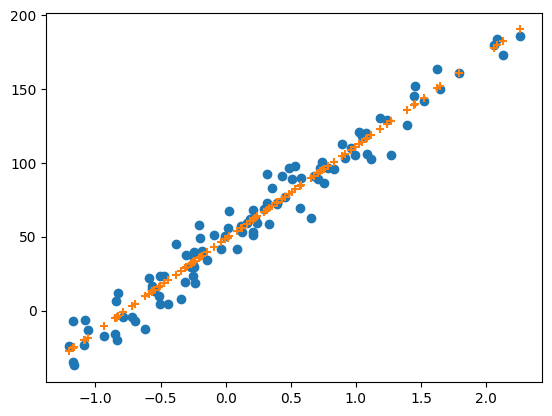

In [15]:
import sklearn.datasets
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate training data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=1,
                                       bias=50.0,
                                       noise=10.0,
                                       random_state=221891)

# package training data into tensorflow Dataset
data = tf.data.Dataset.from_tensor_slices((x,y))

# create and summarize linear model neural network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
model.summary()

# compile model with loss function and optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

# batch data and train model
data = data.batch(10)
model.fit(data, epochs=100)

# predict y values using training data
yhat = model.predict(x)

# plot predicted and true y values
def plot_prediction(x, y_true, y_pred):
  plt.scatter(x, y_true, marker='o')
  plt.scatter(x, y_pred, marker='+')

plot_prediction(x, y, yhat)

You should see the line-fit plot above, preceded by the model training output, and the model summary will be at the very top.

So, that's an end-to-end neural network train-predict analysis, with visualization, in 36 total lines of python code (with comments and decent code structure).

This little code block will form the basis for *all* the neural network training we'll do in this course, and the *exact same* approach underlies similar analyses in research and industry. The only major things different are the size-and-shape of the data and the size-and-shape of the network.